# Grad-ECLIP: Gradient-based Explanation for CLIP Text Encoder

Ce notebook implémente la méthode **Grad-ECLIP** pour l'explicabilité des modèles CLIP au niveau textuel. Nous reproduisons les concepts clés de l'article en montrant comment identifier les mots les plus importants dans une phrase pour la correspondance image-texte.

## Concepts clés de l'article :

1. **Attention-based explanations** : Utilisation des cartes d'attention pour identifier les mots importants
2. **Gradient-based explanations** : Utilisation des gradients pour mesurer l'importance des tokens
3. **Fusion des mécanismes** : Combinaison attention + gradients pour une explication plus robuste


Let's start with using the open sourced OPENAI CLIP model


In [38]:
import re
import math
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, InterpolationMode
import clip

from PIL import Image
from urllib.request import urlopen

import matplotlib.pyplot as plt
from captum.attr import visualization

device = "cuda" if torch.cuda.is_available() else "cpu"
clipmodel, preprocess = clip.load("ViT-B/16", device=device)

## 1. Préparation des données textuelles

La fonction `pre_caption` implémente le préprocessing standard pour les captions, en :

- Normalisant la casse et supprimant la ponctuation
- Limitant la longueur à `max_words` tokens
- Nettoyant les espaces multiples

Cette étape est cruciale car elle standardise l'entrée textuelle avant l'analyse d'explicabilité.


In [39]:
def pre_caption(caption, max_words=50):
    caption = re.sub(
        r"([.!\"()*#:;~])",
        ' ',
        caption.lower(),
    )
    caption = re.sub(
        r"\s{2,}",
        ' ',
        caption,
    )
    caption = caption.rstrip('\n')
    caption = caption.strip(' ')

    # truncate caption
    caption_words = caption.split(' ')
    if len(caption_words) > max_words:
        caption = ' '.join(caption_words[:max_words])

    return caption

## 2. Mécanisme d'attention et encodage dense

### Attention Layer

La fonction `attention_layer` implémente l'attention multi-têtes selon la formule :

**Attention(Q,K,V) = softmax(QK^T/√d_k)V**

où :

- Q, K, V sont les matrices Query, Key, Value
- d_k est la dimension des clés
- Le facteur d'échelle `scaling = 1/√d_k` évite la saturation du softmax

### Encodage dense du texte

`clip_encode_text_dense` modifie l'encodeur CLIP standard pour :

1. **Conserver les représentations intermédiaires** (Q, K, V, attention outputs)
2. **Calculer les cartes d'attention** pour chaque couche
3. **Permettre le calcul de gradients** sur les sorties d'attention

Cette modification est essentielle pour l'explicabilité car elle donne accès aux mécanismes internes du modèle.


In [40]:
def attention_layer(q, k, v, num_heads=1, attn_mask=None):
    "Compute 'Scaled Dot Product Attention'"
    tgt_len, bsz, embed_dim = q.shape
    head_dim = embed_dim // num_heads
    scaling = float(head_dim) ** -0.5
    q = q * scaling

    q = q.contiguous().view(tgt_len, bsz * num_heads, head_dim).transpose(0, 1)
    k = k.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    v = v.contiguous().view(-1, bsz * num_heads, head_dim).transpose(0, 1)
    attn_output_weights = torch.bmm(q, k.transpose(1, 2))
    if attn_mask is not None:
        attn_output_weights += attn_mask
    attn_output_weights = F.softmax(attn_output_weights, dim=-1)
    attn_output = torch.bmm(attn_output_weights, v)
    assert list(attn_output.size()) == [bsz * num_heads, tgt_len, head_dim]
    attn_output = attn_output.transpose(
        0, 1).contiguous().view(tgt_len, bsz, embed_dim)
    attn_output_weights = attn_output_weights.view(bsz, num_heads, tgt_len, -1)
    attn_output_weights = attn_output_weights.sum(dim=1) / num_heads
    return attn_output, attn_output_weights


def clip_encode_text_dense(text, n):
    x = clipmodel.token_embedding(text).type(
        clipmodel.dtype)  # [batch_size, n_ctx, d_model]
    attn_mask = clipmodel.build_attention_mask().to(dtype=x.dtype, device=x.device)
    x = x + clipmodel.positional_embedding.type(clipmodel.dtype)
    x = x.permute(1, 0, 2)  # NLD -> LND
    x = torch.nn.Sequential(*clipmodel.transformer.resblocks[:-n])(x)

    #####################
    attns = []
    atten_outs = []
    vs = []
    qs = []
    ks = []
    for TR in clipmodel.transformer.resblocks[-n:]:
        x_in = x
        x = TR.ln_1(x_in)
        linear = torch._C._nn.linear
        q, k, v = linear(x, TR.attn.in_proj_weight,
                         TR.attn.in_proj_bias).chunk(3, dim=-1)
        attn_output, attn = attention_layer(
            q, k, v, 1, attn_mask=attn_mask)  # num_head=1
        attns.append(attn)
        atten_outs.append(attn_output)
        vs.append(v)
        qs.append(q)
        ks.append(k)

        x_after_attn = linear(
            attn_output, TR.attn.out_proj.weight, TR.attn.out_proj.bias)
        x = x_after_attn + x_in
        x = x + TR.mlp(TR.ln_2(x))

    x = x.permute(1, 0, 2)  # LND -> NLD
    x = clipmodel.ln_final(x).type(clipmodel.dtype)

    # x.shape = [batch_size, n_ctx, transformer.width]
    # take features from the eot embedding (eot_token is the highest number in each sequence)
    x = x[torch.arange(x.shape[0]), text.argmax(dim=-1)
          ] @ clipmodel.text_projection
    return x, (qs, ks, vs), attns, atten_outs

In [41]:
from clip import tokenize
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer
_tokenizer = _Tokenizer()

## 3. Méthodes d'explicabilité

### 3.1 Similarité Q-K (sim_qk)

Cette fonction calcule la similarité cosinus entre :

- Le token `[CLS]` (end-of-sequence) des queries
- Tous les tokens des keys

**Formule** : `cosine_similarity = (q_cls · k_patch) / (||q_cls|| ||k_patch||)`

Cette similarité mesure l'importance relative de chaque token selon le mécanisme d'attention.

### 3.2 Grad-ECLIP : Méthode principale

`grad_eclip` implémente l'algorithme principal de l'article :

1. **Calcul des gradients** : ∇_attn_output(cosine_similarity)
2. **Pondération par attention** : gradient × attention_weights
3. **Agrégation multi-couches** : Somme des contributions de toutes les couches

**Formule finale** : `importance_score = Σ_layers (grad_cls × v × cosine_qk)`

### 3.3 Self-Attention baseline

`self_attn` extrait simplement les poids d'attention du token `[CLS]` vers tous les autres tokens, servant de baseline pour comparaison.


In [42]:
import cv2
import numpy as np


def sim_qk(q, k):
    q_cls = F.normalize(q[eos_position, 0, :], dim=-1)
    k_patch = F.normalize(k[:, 0, :], dim=-1)

    cosine_qk = (q_cls * k_patch).sum(-1)
    cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
    return cosine_qk


def grad_eclip(c, qs, ks, vs, attn_outputs, eos_position):
    # gradient on last attention output
    tmp_maps = []
    for q, k, v, attn_output in zip(qs, ks, vs, attn_outputs):
        grad = torch.autograd.grad(
            c,
            attn_output,
            retain_graph=True)[0]
        grad_cls = grad[eos_position, 0, :]
        # just use the gradient on the cls token position
        cosine_qk = sim_qk(q, k)
        # print("[cosine_qk]:", cosine_qk.shape) # 77
        tmp_maps.append((grad_cls * v[:, 0, :] * cosine_qk[:, None]).sum(-1))

    emap = (F.relu_(torch.stack(tmp_maps, dim=0).sum(0)))
    emap = emap[1:eos_position].flatten()
    emap = emap / emap.sum()
    return emap


def self_attn(attns, eos_position):
    # attn map of cls token on each word
    # attn: 1,77,77

    attn = attns[-1][0, eos_position, :].flatten()
    attn = attn / attn.sum()
    return attn

## 4. Exemple pratique : Analyse d'une image

Nous allons maintenant appliquer Grad-ECLIP sur un exemple concret pour voir quels mots de la description sont les plus importants pour la correspondance image-texte.


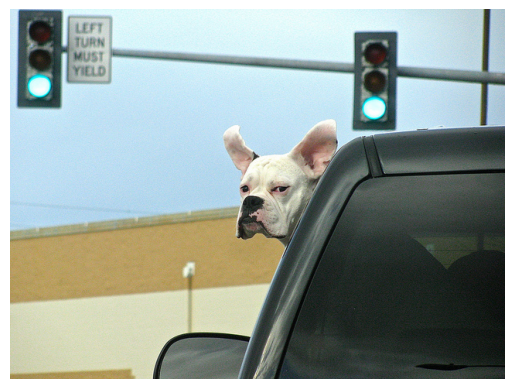

In [43]:
import os
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

img_path = "./images/dog_and_car.png"
img = Image.open(img_path).convert("RGB")
sentence = "dog in a car waiting for traffic lights."

# url = "http://l7.alamy.com/zooms/1e7674256f464050bf142a5d21407ede/single-cowboy-guiding-a-line-of-horses-through-the-desert-bnh6m3.jpg"
# img = Image.open(urlopen(url))
# sentence = "single cowboy guiding a line of horses through the desert"

plt.imshow(img)
plt.axis('off')
plt.show()

## 5. Encodage de l'image

L'image est préprocessée avec les transformations standard de CLIP :

- Redimensionnement à 224×224
- Normalisation RGB
- Encodage par le Vision Transformer

L'embedding image normalisé servira de référence pour mesurer la similarité avec le texte.


In [44]:
# preprocess image and text
img_preprocessed = preprocess(img).cuda().unsqueeze(0)
img_embedding = clipmodel.encode_image(img_preprocessed)
img_embedding = F.normalize(img_embedding, dim=-1)
print("[image embedding]:", img_embedding.shape)

[image embedding]: torch.Size([1, 512])


## 6. Préparation du texte

Tokenisation de la phrase d'entrée :

- Conversion en tokens numériques
- Ajout des tokens spéciaux `[SOS]` et `[EOS]`
- Décodage pour visualisation

La position `[EOS]` est cruciale car elle représente l'embedding global de la phrase dans CLIP.


In [45]:
# sentence = "dog in a car waiting for traffic lights"
text_processed = clip.tokenize([sentence])

text_tokens = _tokenizer.encode(sentence)
text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]

## 7. Calcul de la similarité image-texte

Nous calculons la similarité cosinus entre les embeddings image et texte :

**Similarité = (embedding_image · embedding_text) / (||embedding_image|| ||embedding_text||)**

Cette similarité est la fonction objectif que nous voulons expliquer : quels mots contribuent le plus à cette correspondance image-texte ?


In [46]:
# grad_eclip
x, (qs, ks, vs), attns, atten_outs = clip_encode_text_dense(
    text_processed.cuda(), n=8)
text_embedding = F.normalize(x, dim=-1)
print("[text embedding]:", text_embedding.shape)
cosine = (img_embedding @ text_embedding.T)
eos_position = text_processed.argmax(dim=-1)
print("[eos_position]:", eos_position)
print("[cosine]:", cosine)

[text embedding]: torch.Size([1, 512])
[eos_position]: tensor([10])
[cosine]: tensor([[0.2487]], device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward0>)


## 8. Application de Grad-ECLIP

Nous appliquons maintenant notre méthode d'explicabilité :

1. **Calcul des gradients** de la similarité par rapport aux sorties d'attention
2. **Pondération** par les mécanismes d'attention
3. **Agrégation** pour obtenir un score d'importance par token

Le résultat est un vecteur de scores indiquant l'importance de chaque mot pour la correspondance image-texte.


In [47]:
grad_emap = grad_eclip(cosine[0], qs, ks, vs, atten_outs, eos_position)
print(grad_emap)

tensor([0.2876, 0.1032, 0.0350, 0.1780, 0.0533, 0.0000, 0.1460, 0.1851, 0.0116],
       device='cuda:0', dtype=torch.float16, grad_fn=<DivBackward0>)


## 9. Visualisation des résultats Grad-ECLIP

La visualisation montre les mots les plus importants selon Grad-ECLIP :

- **Intensité de couleur** : Plus c'est foncé, plus le mot est important
- **Scores normalisés** : Les scores sont normalisés pour sommer à 1

Cette méthode combine gradients et attention pour une explication plus robuste que l'attention seule.


In [48]:
vis_data_records = [visualization.VisualizationDataRecord(
    grad_emap, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


## 10. Comparaison avec l'attention pure

Pour comparaison, visualisons aussi les poids d'attention bruts du token `[CLS]` :

Cette baseline montre ce que le modèle "regarde" naturellement, mais sans considérer l'impact sur la similarité finale. La différence avec Grad-ECLIP révèle l'apport des gradients pour l'explicabilité.


In [49]:
attn_word = self_attn(attns, eos_position)
vis_data_records = [visualization.VisualizationDataRecord(
    attn_word, 0, 0, 0, 0, 0, text_tokens_decoded, 1)]
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,dog in a car waiting for traffic lights .


## 11. Traitement en lot : Analyse de plusieurs paires image-texte

Nous allons maintenant traiter plusieurs paires image-texte pour analyser l'explicabilité à plus grande échelle et visualiser les résultats dans une grille organisée.


In [56]:
# Configuration des exemples image-texte
image_text_pairs = [
    {
        "image_path": "./images/cats.jpeg",
        "caption": "two cats sitting on top of apair of shoes.",
        "title": "Cats on Shoes"
    },
    
      {
        "image_path": "./images/car.jpeg",
        "caption": "a car with some surfboards in a field.",
        "title": "dog in a car"
    },
    {
        "image_path": "./images/plant.jpeg",
        "caption": "a small plane flying through a cloudy blue sky",
        "title": "Plane in the Sky"
    },
    
    {
        "image_path": "./images/bird.jpeg",
        "caption": "a bird that is on a tree limb.",
        "title": "Bird on a Tree Limb"
    },
    
    # Ajoutez d'autres paires ici
    # {
    #     "image_path": "./cat_on_sofa.jpg",
    #     "caption": "a cat sleeping on a comfortable sofa",
    #     "title": "Chat sur un canapé"
    # },
    # {
    #     "image_path": "./bird_in_tree.jpg", 
    #     "caption": "colorful bird sitting on a tree branch",
    #     "title": "Oiseau dans un arbre"
    # }
]

# Si vous n'avez qu'une seule image, on peut créer plusieurs captions différentes
single_image_path = "./dog_and_car.png"
multiple_captions = [
    "dog in a car waiting for traffic lights",
    "a small dog sitting in a vehicle",
    "pet animal inside an automobile",
    "canine passenger in a moving car"
]

# Utiliser plusieurs captions pour la même image si pas assez d'images
if len(image_text_pairs) == 1:
    image_text_pairs = []
    for i, caption in enumerate(multiple_captions):
        image_text_pairs.append({
            "image_path": single_image_path,
            "caption": caption,
            "title": f"Description {i+1}"
        })

print(f"Nombre de paires image-texte : {len(image_text_pairs)}")

Nombre de paires image-texte : 4


In [57]:
def process_image_text_pair(image_path, caption):
    """
    Traite une paire image-texte et retourne les scores d'explicabilité
    """
    # Charger et préprocesser l'image
    img = Image.open(image_path).convert("RGB")
    img_preprocessed = preprocess(img).cuda().unsqueeze(0)
    img_embedding = clipmodel.encode_image(img_preprocessed)
    img_embedding = F.normalize(img_embedding, dim=-1)
    
    # Tokeniser le texte
    text_processed = clip.tokenize([caption])
    text_tokens = _tokenizer.encode(caption)
    text_tokens_decoded = [_tokenizer.decode([a]) for a in text_tokens]
    
    # Calculer l'embedding texte avec informations détaillées
    x, (qs, ks, vs), attns, atten_outs = clip_encode_text_dense(
        text_processed.cuda(), n=8)
    text_embedding = F.normalize(x, dim=-1)
    
    # Calculer la similarité
    cosine = (img_embedding @ text_embedding.T)
    eos_position = text_processed.argmax(dim=-1)
    
    # Appliquer Grad-ECLIP
    grad_emap = grad_eclip(cosine[0], qs, ks, vs, atten_outs, eos_position)
    
    # Calculer aussi l'attention pure pour comparaison
    attn_scores = self_attn(attns, eos_position)
    
    return {
        'image': img,
        'caption': caption,
        'tokens': text_tokens_decoded,
        'grad_eclip_scores': grad_emap,
        'attention_scores': attn_scores,
        'similarity': cosine.item(),
        'eos_position': eos_position.item()
    }

# Traiter toutes les paires
results = []
for pair in image_text_pairs:
    print(f"Traitement: {pair['title']}")
    result = process_image_text_pair(pair['image_path'], pair['caption'])
    result['title'] = pair['title']
    results.append(result)
    print(f"  Similarité: {result['similarity']:.3f}")

Traitement: Cats on Shoes
  Similarité: 0.251
Traitement: dog in a car
  Similarité: 0.235
Traitement: Plane in the Sky
  Similarité: 0.230
Traitement: Bird on a Tree Limb
  Similarité: 0.231
  Similarité: 0.231


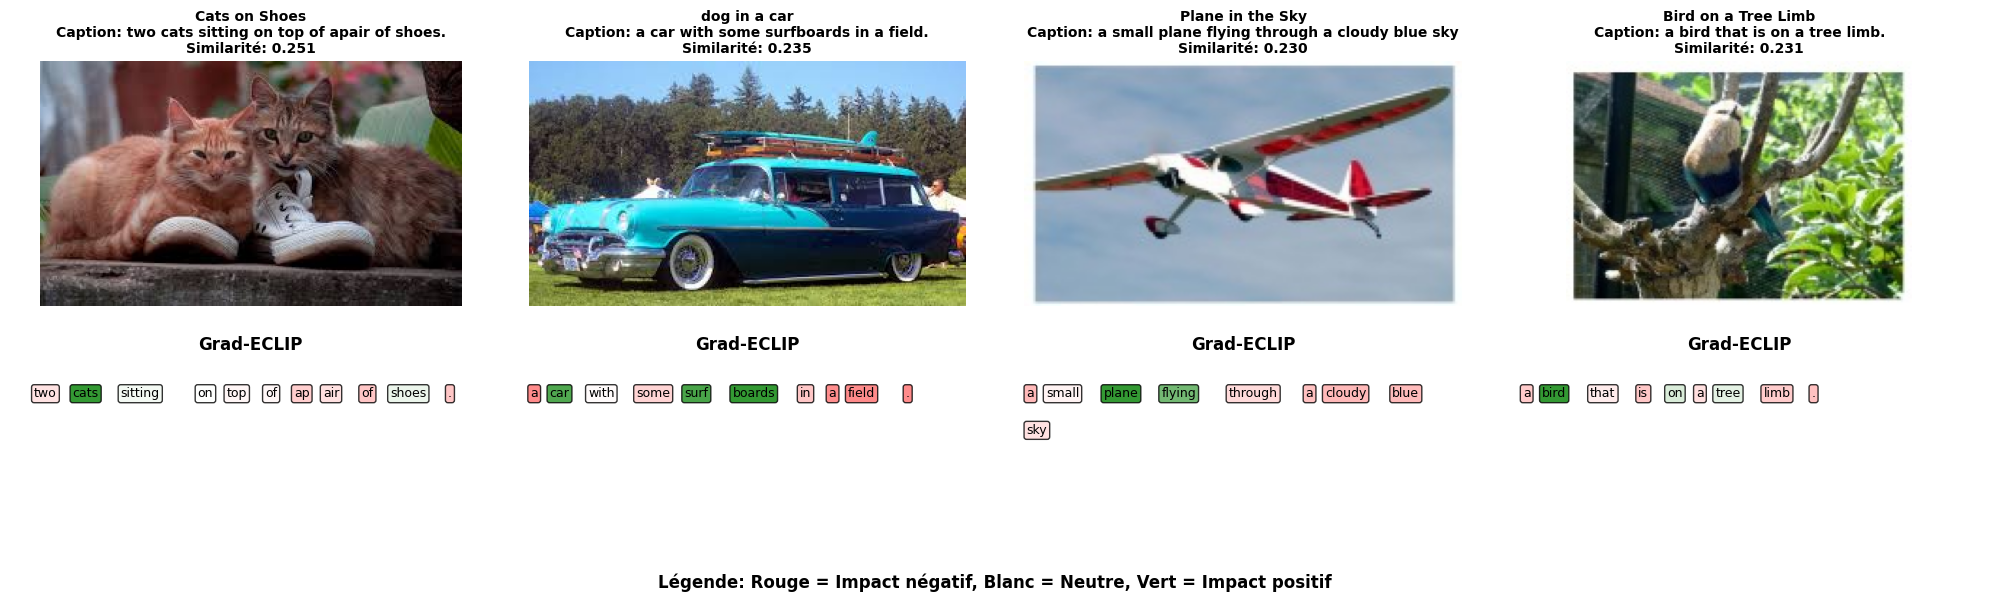


RÉSUMÉ DES ANALYSES GRAD-ECLIP

1. Cats on Shoes
   Caption: two cats sitting on top of apair of shoes.
   Similarité: 0.251
   🎯 Top mots positifs: cats (0.418), shoes (0.121), sitting (0.107)
   🔻 Mots moins pertinents: . (0.000), of (0.000), ap (0.013)

2. dog in a car
   Caption: a car with some surfboards in a field.
   Similarité: 0.235
   🎯 Top mots positifs: boards (0.276), surf (0.256), car (0.251)
   🔻 Mots moins pertinents: field (0.000), a (0.000), . (0.001)

3. Plane in the Sky
   Caption: a small plane flying through a cloudy blue sky
   Similarité: 0.230
   🎯 Top mots positifs: plane (0.438), flying (0.333), small (0.092)
   🔻 Mots moins pertinents: cloudy (0.000), a (0.001), blue (0.003)

4. Bird on a Tree Limb
   Caption: a bird that is on a tree limb.
   Similarité: 0.231
   🎯 Top mots positifs: bird (0.444), on (0.172), tree (0.155)
   🔻 Mots moins pertinents: . (0.012), is (0.020), a (0.028)


In [59]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

def add_colored_text_to_ax(tokens, scores, ax, method_name):
    """
    Ajoute du texte coloré directement sur un axe matplotlib
    Utilise rouge pour négatif, blanc pour neutre, vert pour positif
    """
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')
    
    # Titre de la méthode
    ax.text(0.5, 0.9, method_name, ha='center', va='center', 
            fontsize=12, fontweight='bold', transform=ax.transAxes)
    
    # Normaliser les scores entre -1 et 1 pour le schéma rouge-blanc-vert
    if len(scores) > 0 and scores.max() > scores.min():
        # Centrer les scores autour de 0
        scores_mean = scores.mean()
        scores_centered = scores - scores_mean
        scores_max = max(abs(scores_centered.max()), abs(scores_centered.min()))
        if scores_max > 0:
            scores_norm = scores_centered / scores_max  # Entre -1 et 1
        else:
            scores_norm = torch.zeros_like(scores)
    else:
        scores_norm = torch.zeros_like(scores)
    
    # Créer une colormap rouge-blanc-vert
    colors_list = ['red', 'white', 'green']
    cmap = LinearSegmentedColormap.from_list('rwg', colors_list, N=256)
    
    # Créer le texte avec coloration
    text_parts = []
    colors = []
    
    for i, (token, score) in enumerate(zip(tokens, scores_norm)):
        clean_token = token.replace('</w>', '').replace('<|startoftext|>', '').replace('<|endoftext|>', '')
        if clean_token.strip():
            text_parts.append(clean_token)
            # Couleur basée sur le score normalisé (-1 à 1)
            # Convertir de [-1,1] vers [0,1] pour la colormap
            color_value = (float(score) + 1) / 2  # -1->0, 0->0.5, 1->1
            colors.append(cmap(color_value))
    
    # Afficher le texte ligne par ligne
    text_str = ' '.join(text_parts)
    words = text_str.split()
    
    y_pos = 0.7
    x_pos = 0.05
    line_height = 0.15
    
    for i, word in enumerate(words):
        if i < len(colors):
            # Calculer la largeur approximative du mot
            word_width = len(word) * 0.02
            
            # Passer à la ligne si nécessaire
            if x_pos + word_width > 0.95:
                x_pos = 0.05
                y_pos -= line_height
            
            # Ajouter le mot avec sa couleur de fond
            bbox_props = dict(boxstyle="round,pad=0.2", facecolor=colors[i], alpha=0.8)
            ax.text(x_pos, y_pos, word, fontsize=9, bbox=bbox_props, 
                   ha='left', va='center', transform=ax.transAxes)
            
            x_pos += word_width + 0.02

def visualize_results_grid(results):
    """
    Affiche une grille avec images et texte coloré Grad-ECLIP uniquement
    """
    n_results = len(results)
    n_cols = min(4, n_results)  # Maximum 3 colonnes
    n_rows = (n_results + n_cols - 1) // n_cols
    
    # Créer la grille principale (seulement image + Grad-ECLIP)
    fig = plt.figure(figsize=(5 * n_cols, 6 * n_rows))
    
    for i, result in enumerate(results):
        # Position dans la grille
        row = i // n_cols
        col = i % n_cols
        
        # Créer les sous-axes pour chaque résultat (image + Grad-ECLIP seulement)
        # Image (plus grande)
        ax_img = plt.subplot2grid((n_rows * 2, n_cols), (row * 2, col), 
                                 rowspan=1, colspan=1)
        ax_img.imshow(result['image'])
        ax_img.set_title(f"{result['title']}\nCaption: {result['caption'][:50]}{'...' if len(result['caption']) > 50 else ''}\nSimilarité: {result['similarity']:.3f}", 
                        fontsize=10, fontweight='bold')
        ax_img.axis('off')
        
        # Grad-ECLIP seulement
        ax_grad = plt.subplot2grid((n_rows * 2, n_cols), (row * 2 + 1, col), 
                                  rowspan=1, colspan=1)
        add_colored_text_to_ax(result['tokens'], result['grad_eclip_scores'], 
                              ax_grad, "Grad-ECLIP")
    
    # Ajouter une légende pour les couleurs
    fig.text(0.5, 0.02, 'Légende: Rouge = Impact négatif, Blanc = Neutre, Vert = Impact positif', 
             ha='center', va='center', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.05)  # Laisser de l'espace pour la légende
    plt.show()
    
    # Afficher un résumé textuel
    print("\n" + "="*80)
    print("RÉSUMÉ DES ANALYSES GRAD-ECLIP")
    print("="*80)
    
    for i, result in enumerate(results):
        print(f"\n{i+1}. {result['title']}")
        print(f"   Caption: {result['caption']}")
        print(f"   Similarité: {result['similarity']:.3f}")
        
        # Top mots selon Grad-ECLIP
        grad_scores = result['grad_eclip_scores']
        tokens = result['tokens']
        
        if len(grad_scores) > 0:
            valid_grad_scores = grad_scores[:len(tokens)]
            if len(valid_grad_scores) > 0:
                # Top 3 mots les plus importants (positifs)
                top_grad_indices = torch.topk(valid_grad_scores, min(3, len(valid_grad_scores))).indices
                top_grad_words = []
                for idx in top_grad_indices:
                    if idx < len(tokens):
                        clean_word = tokens[idx].replace('</w>', '').replace('<|startoftext|>', '').replace('<|endoftext|>', '').strip()
                        if clean_word:
                            score_val = valid_grad_scores[idx].item()
                            top_grad_words.append(f"{clean_word} ({score_val:.3f})")
                print(f"   🎯 Top mots positifs: {', '.join(top_grad_words)}")
                
                # Top 3 mots les moins importants (négatifs)
                bottom_grad_indices = torch.topk(valid_grad_scores, min(3, len(valid_grad_scores)), largest=False).indices
                bottom_grad_words = []
                for idx in bottom_grad_indices:
                    if idx < len(tokens):
                        clean_word = tokens[idx].replace('</w>', '').replace('<|startoftext|>', '').replace('<|endoftext|>', '').strip()
                        if clean_word:
                            score_val = valid_grad_scores[idx].item()
                            bottom_grad_words.append(f"{clean_word} ({score_val:.3f})")
                print(f"   🔻 Mots moins pertinents: {', '.join(bottom_grad_words)}")

# Visualiser tous les résultats en grille
visualize_results_grid(results)